In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from torch.nn import Module
import torch
import torch.nn as nn
import torch.optim as optim
import shutil

In [238]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
car = pd.read_csv('./carData/companies.csv')
car.head(20)

rank                                          logo_link          origin  \
0      1  https://www.carlogos.org/car-logos/toyota-logo...           Japan   
1      2  https://www.carlogos.org/car-logos/honda-logo.png           Japan   
2      3  https://www.carlogos.org/car-logos/chevrolet-l...   United States   
3      4   https://www.carlogos.org/car-logos/ford-logo.png   United States   
4      5  https://www.carlogos.org/car-logos/mercedes-be...         Germany   
5      6   https://www.carlogos.org/car-logos/jeep-logo.png   United States   
6      7    https://www.carlogos.org/car-logos/bmw-logo.png         Germany   
7      8  https://www.carlogos.org/car-logos/porsche-log...         Germany   
8      9  https://www.carlogos.org/car-logos/subaru-logo...           Japan   
9     10  https://www.carlogos.org/car-logos/nissan-logo...           Japan   
10    11  https://www.carlogos.org/car-logos/cadillac-lo...   United States   
11    12  https://www.carlogos.org/car-logos/volkswagen-...         Germany   
12    13  https://www.carlogos.org/car-logos/lexus-logo.png           Japan   
13    14   https://www.carlogos.org/car-logos/audi-logo.png         Germany   
14    15  https://www.carlogos.org/car-logos/ferrari-log...           Italy   
15    16  https://www.carlogos.org/car-logos/volvo-logo.png          Sweden   
16    17  https://www.carlogos.org/car-logos/jaguar-logo...  United Kingdom   
17    18    https://www.carlogos.org/car-logos/gmc-logo.png   United States   
18    19  https://www.carlogos.org/car-logos/buick-logo.png   United States   
19    20  https://www.carlogos.org/car-logos/acura-logo.png           Japan   

             name                   segment  
0          Toyota          Mass-Market Cars  
1           Honda          Mass-Market Cars  
2       Chevrolet          Mass-Market Cars  
3            Ford          Mass-Market Cars  
4   Mercedes-Benz           Luxury Vehicles  
5            Jeep    Sport Utility Vehicles  
6             BMW           Luxury Vehicles  
7         Porsche        Luxury Sports Cars  
8          Subaru          Mass-Market Cars  
9          Nissan          Mass-Market Cars  
10       Cadillac           Luxury Vehicles  
11     Volkswagen          Mass-Market Cars  
12          Lexus           Luxury Vehicles  
13           Audi           Luxury Vehicles  
14        Ferrari  Super Luxury Sports Cars  
15          Volvo           Luxury Vehicles  
16         Jaguar           Luxury Vehicles  
17            GMC             Pickup Trucks  
18          Buick          Mass-Market Cars  
19          Acura           Luxury Vehicles

In [129]:
data_dir = "./carData/imgs_zip/imgs/"

img_width = 224
img_height = 224

batch_size = 32
# Set train-validation split ratio
split_ratio = 0.8

# Load and transform images into a Pytorch dataset

In [237]:
from torch.utils.data import Dataset, DataLoader
import torchvision

# Transformation to match ResNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Pytorch dataset
class CarDb(Dataset):
    def __init__(self, car_list):
        self.file_path = [path for path, _ in car_list if torchvision.io.read_image(path).shape[0] == 3]
        self.labels = [label for path, label in car_list if torchvision.io.read_image(path).shape[0] == 3]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
    # retrieves a single sample (image, label)
        label = self.labels[idx]
        file_path = self.file_path[idx]
        img = Image.open(file_path)
        img = transform(img) # squared, rescaled image 124x124
        return (img, label)

In [135]:
# Iterate all folders and files and create the dataset
src_path = './carData/imgs_zip/imgs/'
car_list = [(os.path.join(src_path, folder_path,file),folder_path) for folder_path in os.listdir(src_path)
            if os.path.isdir(os.path.join(src_path, folder_path))  # Check if it's a directory
            for file in os.listdir(os.path.join(src_path, folder_path))
            if file.endswith('.jpg')]

df = CarDb(car_list)
df.to(device) # move to GPU (if available)

# Visualize some random images

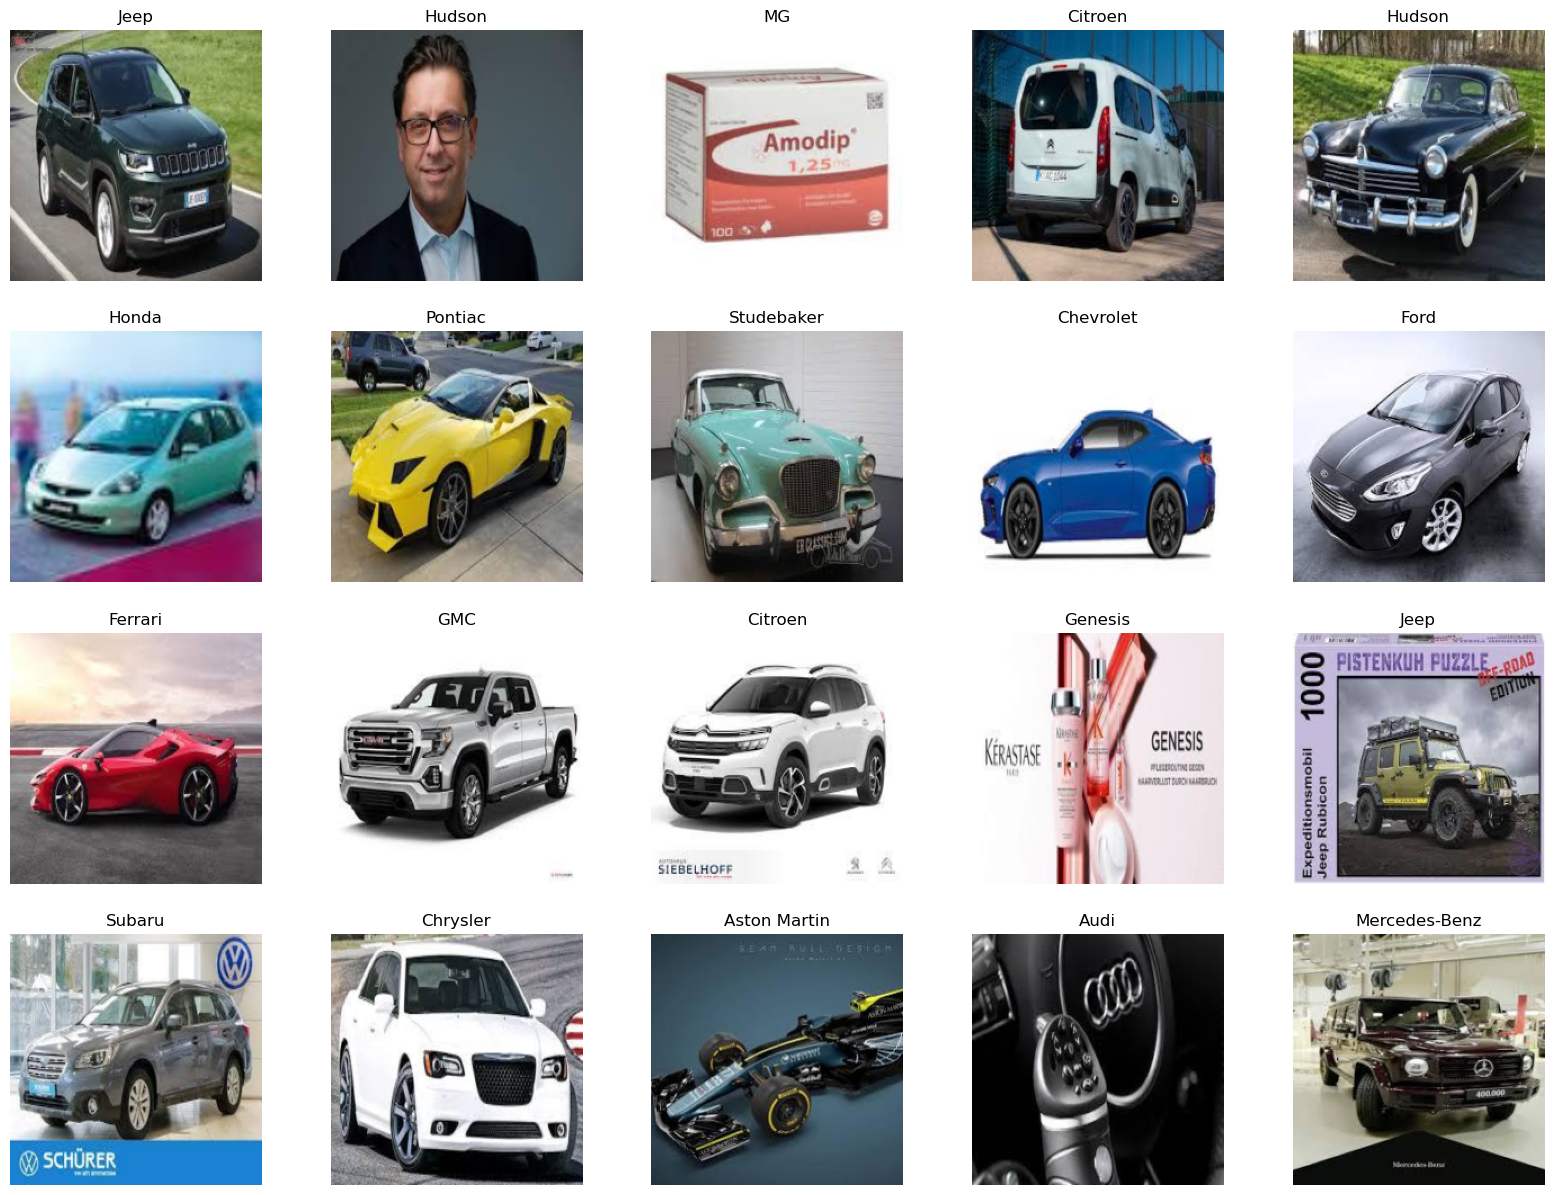

In [85]:
import random

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]  # Undo normalization
    return img.clamp(0, 1)  # Ensure values are in the range [0, 1]

N = len(df)
samples = [random.randint(0, N - 1) for _ in range(20)] # retrieve 20 random samples
plt.figure(figsize=(20,15))
for i, idx in enumerate(samples):
    img, label = df[idx]
    plt.subplot(4,5,i+1)
#    plt.imshow(img.permute(1,2,0).numpy())
    plt.imshow(denormalize(img).squeeze().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(label)

# Detecting outliers

## 1. Unsupervised Clustering

In [89]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
model.eval()

# 1. Extract features
def extract_feature(image):
    with torch.no_grad():
        feature = model(image.unsqueeze(0)).squeeze().numpy()
    return feature

def extract_features_from_dataset(dataset):
    features = []
    file_paths = []

    for idx in range(len(dataset)):
        img, _ = dataset[idx]
        feature = extract_feature(img)
        features.append(feature)
        file_paths.append(dataset.file_path[idx])

    return torch.tensor(features), file_paths

/home/eqa7yg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eqa7yg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [90]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2. Cluster features
def cluster_features(features, n_clusters=5):
    # Dimensionality reduction for clustering
    pca = PCA(n_components=50)
    reduced_features = pca.fit_transform(features)

    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced_features)
    return clusters

# 3. Visualize clusters
def visualize_clusters(dataset, clusters, file_paths, n_samples=5):
    unique_clusters = set(clusters.tolist())
    for cluster_id in unique_clusters:
        print(f"\nCluster {cluster_id}:")
        cluster_images = [file_paths[i] for i, c in enumerate(clusters) if c == cluster_id][:n_samples]

        plt.figure(figsize=(15, 5))
        for j, img_path in enumerate(cluster_images):
            try:
                img = Image.open(img_path)
                plt.subplot(1, n_samples, j + 1)
                plt.imshow(img)
                plt.title(f"Cluster {cluster_id}")
                plt.axis('off')
            except Exception as e:
                print(f"Error displaying image {img_path}: {e}")
        plt.show()

In [91]:
dataset = CarDb(car_list)

# Step 1: Extract features
features, file_paths = extract_features_from_dataset(dataset)

/tmp/ipykernel_280113/1806531326.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(features), file_paths


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Cluster 0:


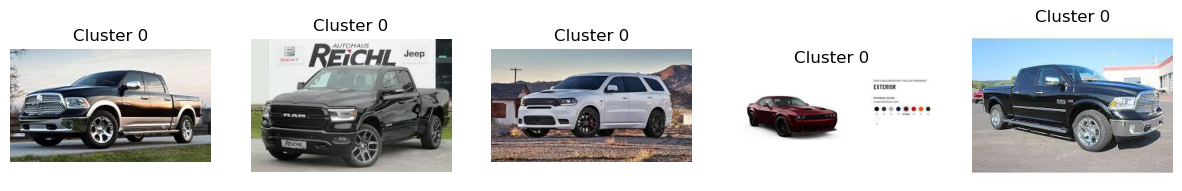


Cluster 1:


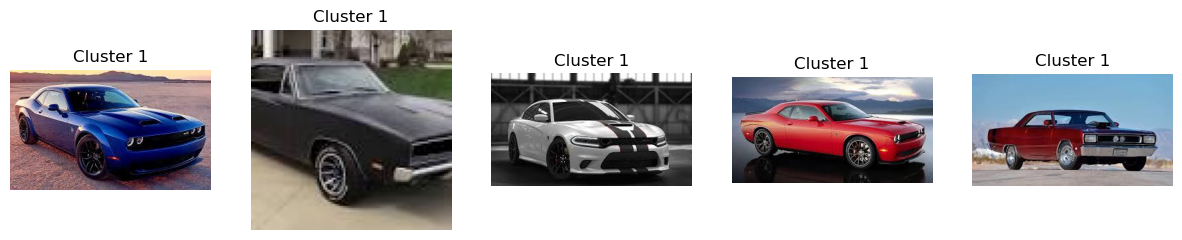


Cluster 2:


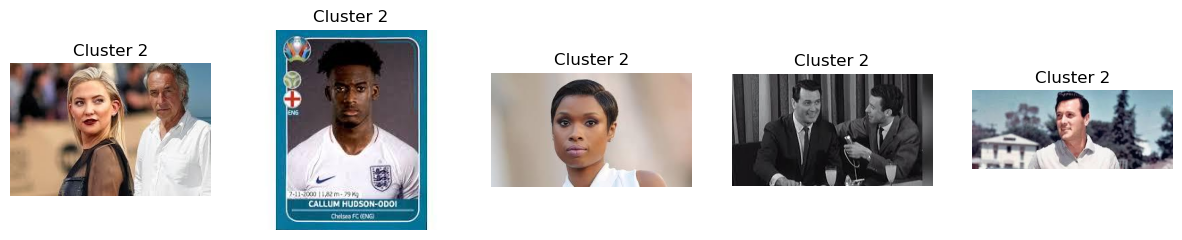


Cluster 3:


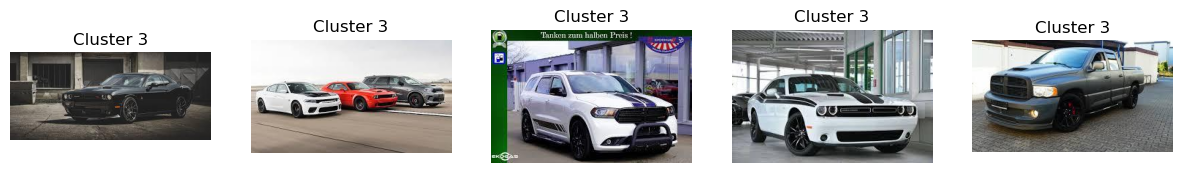


Cluster 4:


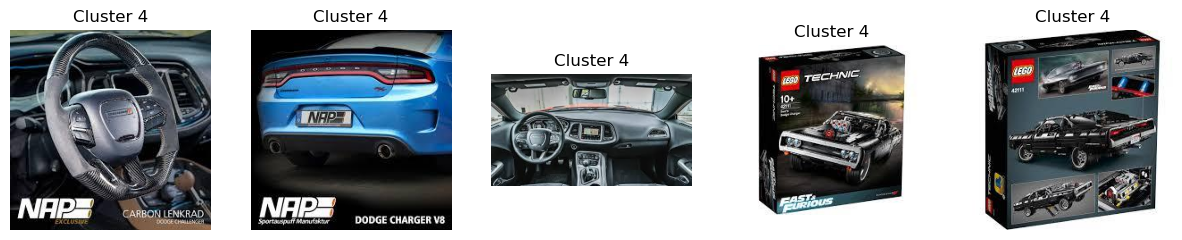

In [100]:
# Step 2: Cluster features
clusters = cluster_features(features, 5)

# Step 3: Visualize clusters
visualize_clusters(dataset, clusters, file_paths)


Cluster 2:


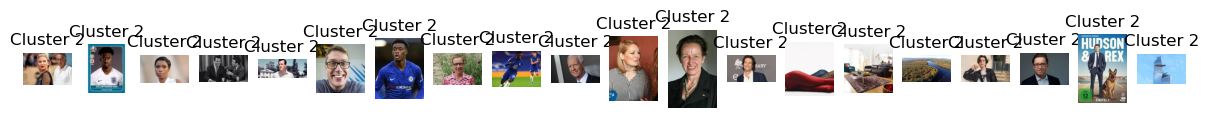

In [104]:
unique_clusters = set(clusters.tolist())
cluster_id = 2
n_samples = 20
print(f"\nCluster {cluster_id}:")
cluster_images = [file_paths[i] for i, c in enumerate(clusters) if c == cluster_id][:n_samples]

plt.figure(figsize=(15, 5))
for j, img_path in enumerate(cluster_images):
    try:
        img = Image.open(img_path)
        plt.subplot(1, n_samples, j + 1)
        plt.imshow(img)
        plt.title(f"Cluster {cluster_id}")
        plt.axis('off')
    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")
plt.show()

## 2. ResNet2 Pretrained labels

In [106]:
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")
print("Downloaded ImageNet class labels.")

Downloaded ImageNet class labels.


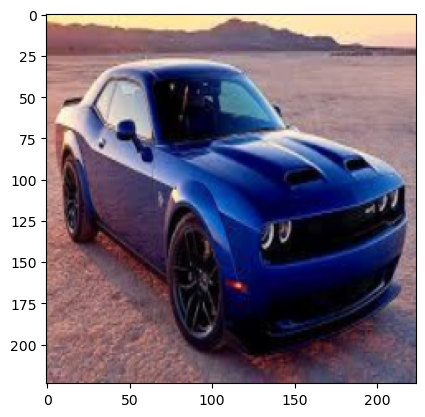

In [145]:
plt.imshow(denormalize(dataset[1][0]).squeeze().permute(1, 2, 0))

In [206]:
list(LABELS.items())[:10]

[(0, 'tench'),
 (1, 'goldfish'),
 (2, 'great white shark'),
 (3, 'tiger shark'),
 (4, 'hammerhead'),
 (5, 'electric ray'),
 (6, 'stingray'),
 (7, 'cock'),
 (8, 'hen'),
 (9, 'ostrich')]

In [207]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
model.eval()

/home/eqa7yg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eqa7yg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [248]:
LABELS = {n: label.strip() for n, label in enumerate(open("imagenet_classes.txt"))}
car_keywords = [
    "car", "convertible", "minivan", "taxi", "cab", "limousine", "trailer truck","racer","moving van",
    "race car", "sports car", "jeep", "pickup", "SUV", "wagon", "beach wagon",
    "police car", "ambulance", "fire truck", "tow truck", "truck", "bus", "van"
]

def predict_image(image):
    try:
        with torch.no_grad():
            outputs = model(image.unsqueeze(0))
        _, predicted = outputs.max(1)
        label = LABELS[predicted.item()]
        return label
    except Exception as e:
        print(f"Error processing {image}: {e}")
        return None
    
def filter_non_car_images(dataset):
    non_car_images = []

    for idx in range(len(dataset)):
        img, label = dataset[idx]
        predicted_label = predict_image(img) # Predict the label using the model
        if predicted_label not in car_keywords: # Check if the predicted label is not related to a car
            non_car_images.append((dataset.file_path[idx], predicted_label))
    print(f"\nTotal non-car images detected: {len(non_car_images)}")
    return non_car_images

non_car_images = filter_non_car_images(dataset)


Total non-car images detected: 765


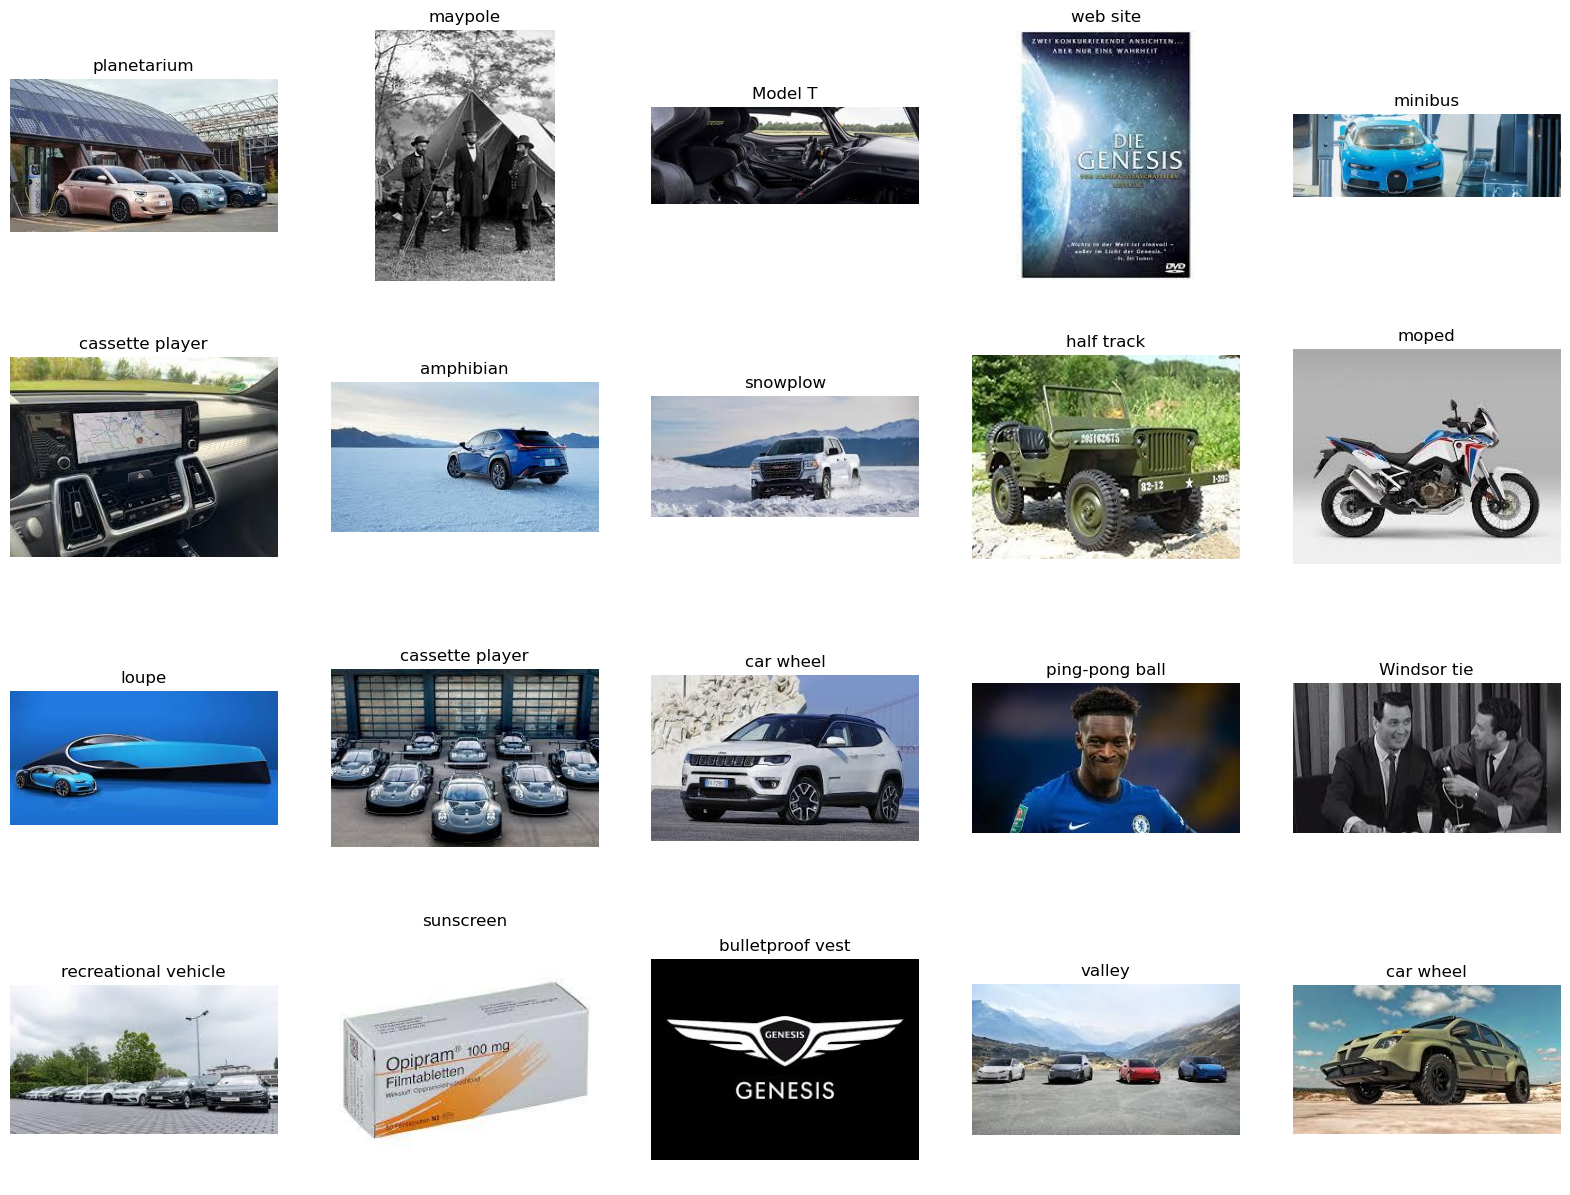

In [249]:
import random

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]  # Undo normalization
    return img.clamp(0, 1)  # Ensure values are in the range [0, 1]

N = len(non_car_images)
samples = [random.randint(0, N - 1) for _ in range(20)] # retrieve 20 random samples
plt.figure(figsize=(20,15))
for i, idx in enumerate(samples):
    img_path, label = non_car_images[idx]
    plt.subplot(4,5,i+1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)

## 3. Image similarity

In [ ]:
from scipy.spatial.distance import cosine

# Calculate pairwise similarity (cosine similarity)
def calculate_similarity(features):
    similarities = []
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            similarity = 1 - cosine(features[i], features[j])
            similarities.append(similarity)
    return np.array(similarities)

# Calculate pairwise similarities
similarity_scores = calculate_similarity(features)
print(f"Mean similarity: {np.mean(similarity_scores)}")

# Model Training

In [262]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Split data into train, val and test
train_df, test_df, val_df = torch.utils.data.random_split(dataset, 
                                                          [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

loaders = {
    "train": DataLoader(train_df, batch_size=64, shuffle=True),
    "val": DataLoader(val_df, batch_size=64, shuffle=True),
    "test": DataLoader(test_df, batch_size=64, shuffle=True)
}

# Test data loaders
img, label = next(iter(loaders["train"]))

In [271]:
# Get number of classes
num_classes = len(set(dataset.labels))

# Load pretrained ResNet-18
resnet_model = torchvision.models.resnet18(pretrained=True)
# Modify the last layer for car classification
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device) # Move model to device

/home/eqa7yg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 3.7581, Valid Loss: 4.1618, Accuracy: 9.38%
Epoch [2/10], Train Loss: 3.2678, Valid Loss: 3.1581, Accuracy: 18.28%
Epoch [3/10], Train Loss: 2.8555, Valid Loss: 2.7415, Accuracy: 25.46%
Epoch [4/10], Train Loss: 2.4737, Valid Loss: 2.3036, Accuracy: 37.63%
Epoch [5/10], Train Loss: 2.1953, Valid Loss: 2.3255, Accuracy: 37.21%
Epoch [6/10], Train Loss: 1.9012, Valid Loss: 2.9061, Accuracy: 30.74%
Epoch [7/10], Train Loss: 1.6308, Valid Loss: 1.8470, Accuracy: 50.45%
Epoch [8/10], Train Loss: 1.3281, Valid Loss: 1.5355, Accuracy: 57.63%
Epoch [9/10], Train Loss: 1.1257, Valid Loss: 1.1931, Accuracy: 67.06%
Epoch [10/10], Train Loss: 0.9110, Valid Loss: 0.8959, Accuracy: 75.37%


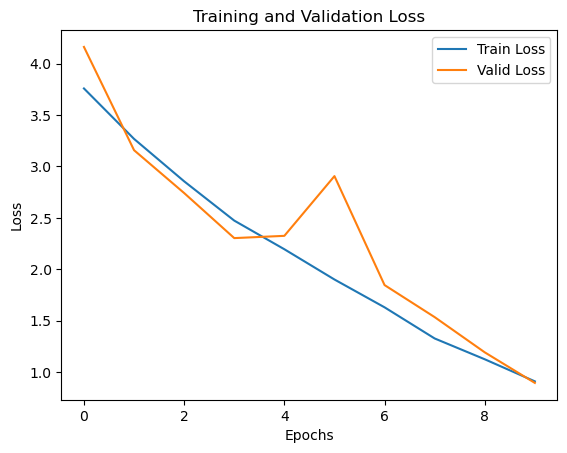

CPU times: user 9min, sys: 6.34 s, total: 9min 6s
Wall time: 3min 11s


In [10]:
%%time


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        accuracy = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, valid_losses

# Train the model
train_losses, valid_losses = train_model(resnet_model, train_loader, valid_loader, criterion, optimizer, epochs=10)

# Save the model
torch.save(resnet_model.state_dict(), "resnet_car_classifier.pth")

# Plot loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Epoch [1/10], Train Loss: 3.4811, Valid Loss: 2.7023, Accuracy: 35.01%
Epoch [2/10], Train Loss: 2.3695, Valid Loss: 1.9052, Accuracy: 55.96%
Epoch [3/10], Train Loss: 1.5551, Valid Loss: 1.1569, Accuracy: 72.76%
Epoch [4/10], Train Loss: 0.9779, Valid Loss: 0.8032, Accuracy: 81.54%
Epoch [5/10], Train Loss: 0.6095, Valid Loss: 0.4973, Accuracy: 89.67%
Epoch [6/10], Train Loss: 0.3535, Valid Loss: 0.3761, Accuracy: 92.23%
Epoch [7/10], Train Loss: 0.2197, Valid Loss: 0.2832, Accuracy: 94.07%
Epoch [8/10], Train Loss: 0.1364, Valid Loss: 0.2657, Accuracy: 93.95%
Epoch [9/10], Train Loss: 0.0935, Valid Loss: 0.2367, Accuracy: 94.72%
Epoch [10/10], Train Loss: 0.0734, Valid Loss: 0.2336, Accuracy: 94.60%


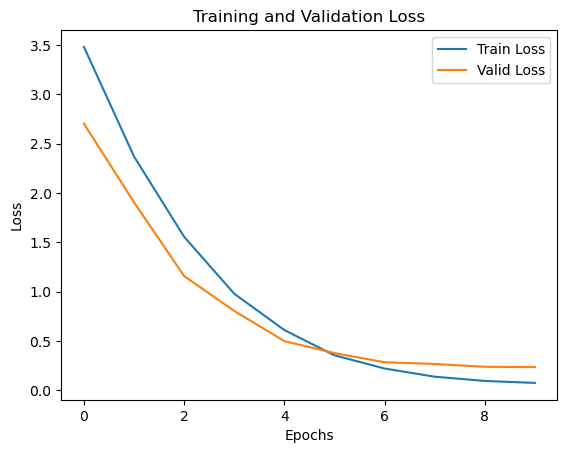

CPU times: user 9min 39s, sys: 17.9 s, total: 9min 57s
Wall time: 3min 58s


In [13]:
%%time
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
train_dir = "/home/nps3cs/Documents/MSDS/SpringMSDS/carData/car_imgs/train"
valid_dir = "/home/nps3cs/Documents/MSDS/SpringMSDS/carData/car_imgs/valid"

# Image transformations (with augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=valid_dir, transform=transform)

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Get number of classes
num_classes = len(train_dataset.classes)

# Load pretrained ResNet-50
resnet_model = torchvision.models.resnet50(pretrained=True)

# Modify the last layer for car classification
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move model to device
resnet_model = resnet_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0001, weight_decay=1e-4)


# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        accuracy = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, valid_losses

# Train the model
train_losses, valid_losses = train_model(resnet_model, train_loader, valid_loader, criterion, optimizer, epochs=10)

# Save the model
torch.save(resnet_model.state_dict(), "resnet_car_classifier.pth")

# Plot loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()